In [1]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
%pwd

'/content'

In [4]:
print(tf.__version__)

2.15.0


In [5]:
%cd gdrive/MyDrive/Landmark-Recognition/

/content/gdrive/MyDrive/Landmark-Recognition


In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
image_dir = Path('Dataset')

In [8]:
filepaths = list(image_dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(200, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [9]:
image_df

,Filepath,Label
0,Dataset/Gedung-Sate/Gedung-Sate (19).jpg,Gedung-Sate
1,Dataset/Gedung-Sate/Gedung-Sate (137).jpg,Gedung-Sate
2,Dataset/Tugu-Jogja/Tugu-Jogja (241).jpg,Tugu-Jogja
3,Dataset/Suro-Boyo/Suro-Boyo (122).jpg,Suro-Boyo
4,Dataset/Tugu-Jogja/Tugu-Jogja (57).jpg,Tugu-Jogja
...,...,...
1195,Dataset/Gedung-Sate/Gedung-Sate (159).jpg,Gedung-Sate
1196,Dataset/Candi-Borobudur/Candi-Borobudur (13).jpg,Candi-Borobudur
1197,Dataset/Tugu-Jogja/Tugu-Jogja (162).jpg,Tugu-Jogja
1198,Dataset/Tugu-Monas/Tugu-Monas (325).jpg,Tugu-Monas


In [10]:
image_df['Label'].value_counts()

Gedung-Sate        200
Tugu-Jogja         200
Suro-Boyo          200
Tugu-Monas         200
Candi-Borobudur    200
Patung-GWK         200
Name: Label, dtype: int64

In [11]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
test_df.value_counts()

Filepath                                           Label          
Dataset/Candi-Borobudur/Candi-Borobudur (10).jpeg  Candi-Borobudur    1
Dataset/Candi-Borobudur/Candi-Borobudur (133).jpg  Candi-Borobudur    1
Dataset/Tugu-Jogja/Tugu-Jogja (219).jpg            Tugu-Jogja         1
Dataset/Tugu-Jogja/Tugu-Jogja (218).jpg            Tugu-Jogja         1
Dataset/Tugu-Jogja/Tugu-Jogja (210).jpg            Tugu-Jogja         1
                                                                     ..
Dataset/Gedung-Sate/Gedung-Sate (98).jpg           Gedung-Sate        1
Dataset/Gedung-Sate/Gedung-Sate (52).jpg           Gedung-Sate        1
Dataset/Gedung-Sate/Gedung-Sate (34).jpg           Gedung-Sate        1
Dataset/Gedung-Sate/Gedung-Sate (30).jpg           Gedung-Sate        1
Dataset/Tugu-Monas/Tugu-Monas (79).jpg             Tugu-Monas         1
Length: 120, dtype: int64

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

Found 972 validated image filenames belonging to 6 classes.
Found 108 validated image filenames belonging to 6 classes.
Found 120 validated image filenames belonging to 6 classes.


In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
# x = tf.keras.layers.Dropout(0.01)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nThe accuracy already reaches 90%.")
      self.model.stop_training = True

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = myCallback()

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
122/122 [==============================] - 347s 3s/step - loss: 0.8510 - accuracy: 0.6718 - val_loss: 0.3798 - val_accuracy: 0.8704
Epoch 2/100
122/122 [==============================] - 19s 155ms/step - loss: 0.3865 - accuracy: 0.8776 - val_loss: 0.5532 - val_accuracy: 0.8426
Epoch 3/100
122/122 [==============================] - 20s 164ms/step - loss: 0.2803 - accuracy: 0.9033 - val_loss: 0.5993 - val_accuracy: 0.7963
Epoch 4/100
122/122 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9126
The accuracy already reaches 90%.
122/122 [==============================] - 20s 163ms/step - loss: 0.2662 - accuracy: 0.9126 - val_loss: 0.3222 - val_accuracy: 0.9167


# New Section

In [18]:
results = model.evaluate(test_images, verbose=2)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

15/15 - 34s - loss: 0.2981 - accuracy: 0.9000 - 34s/epoch - 2s/step
Test Accuracy: 90.00%


In [19]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

15/15 [==============================] - 2s 35ms/step


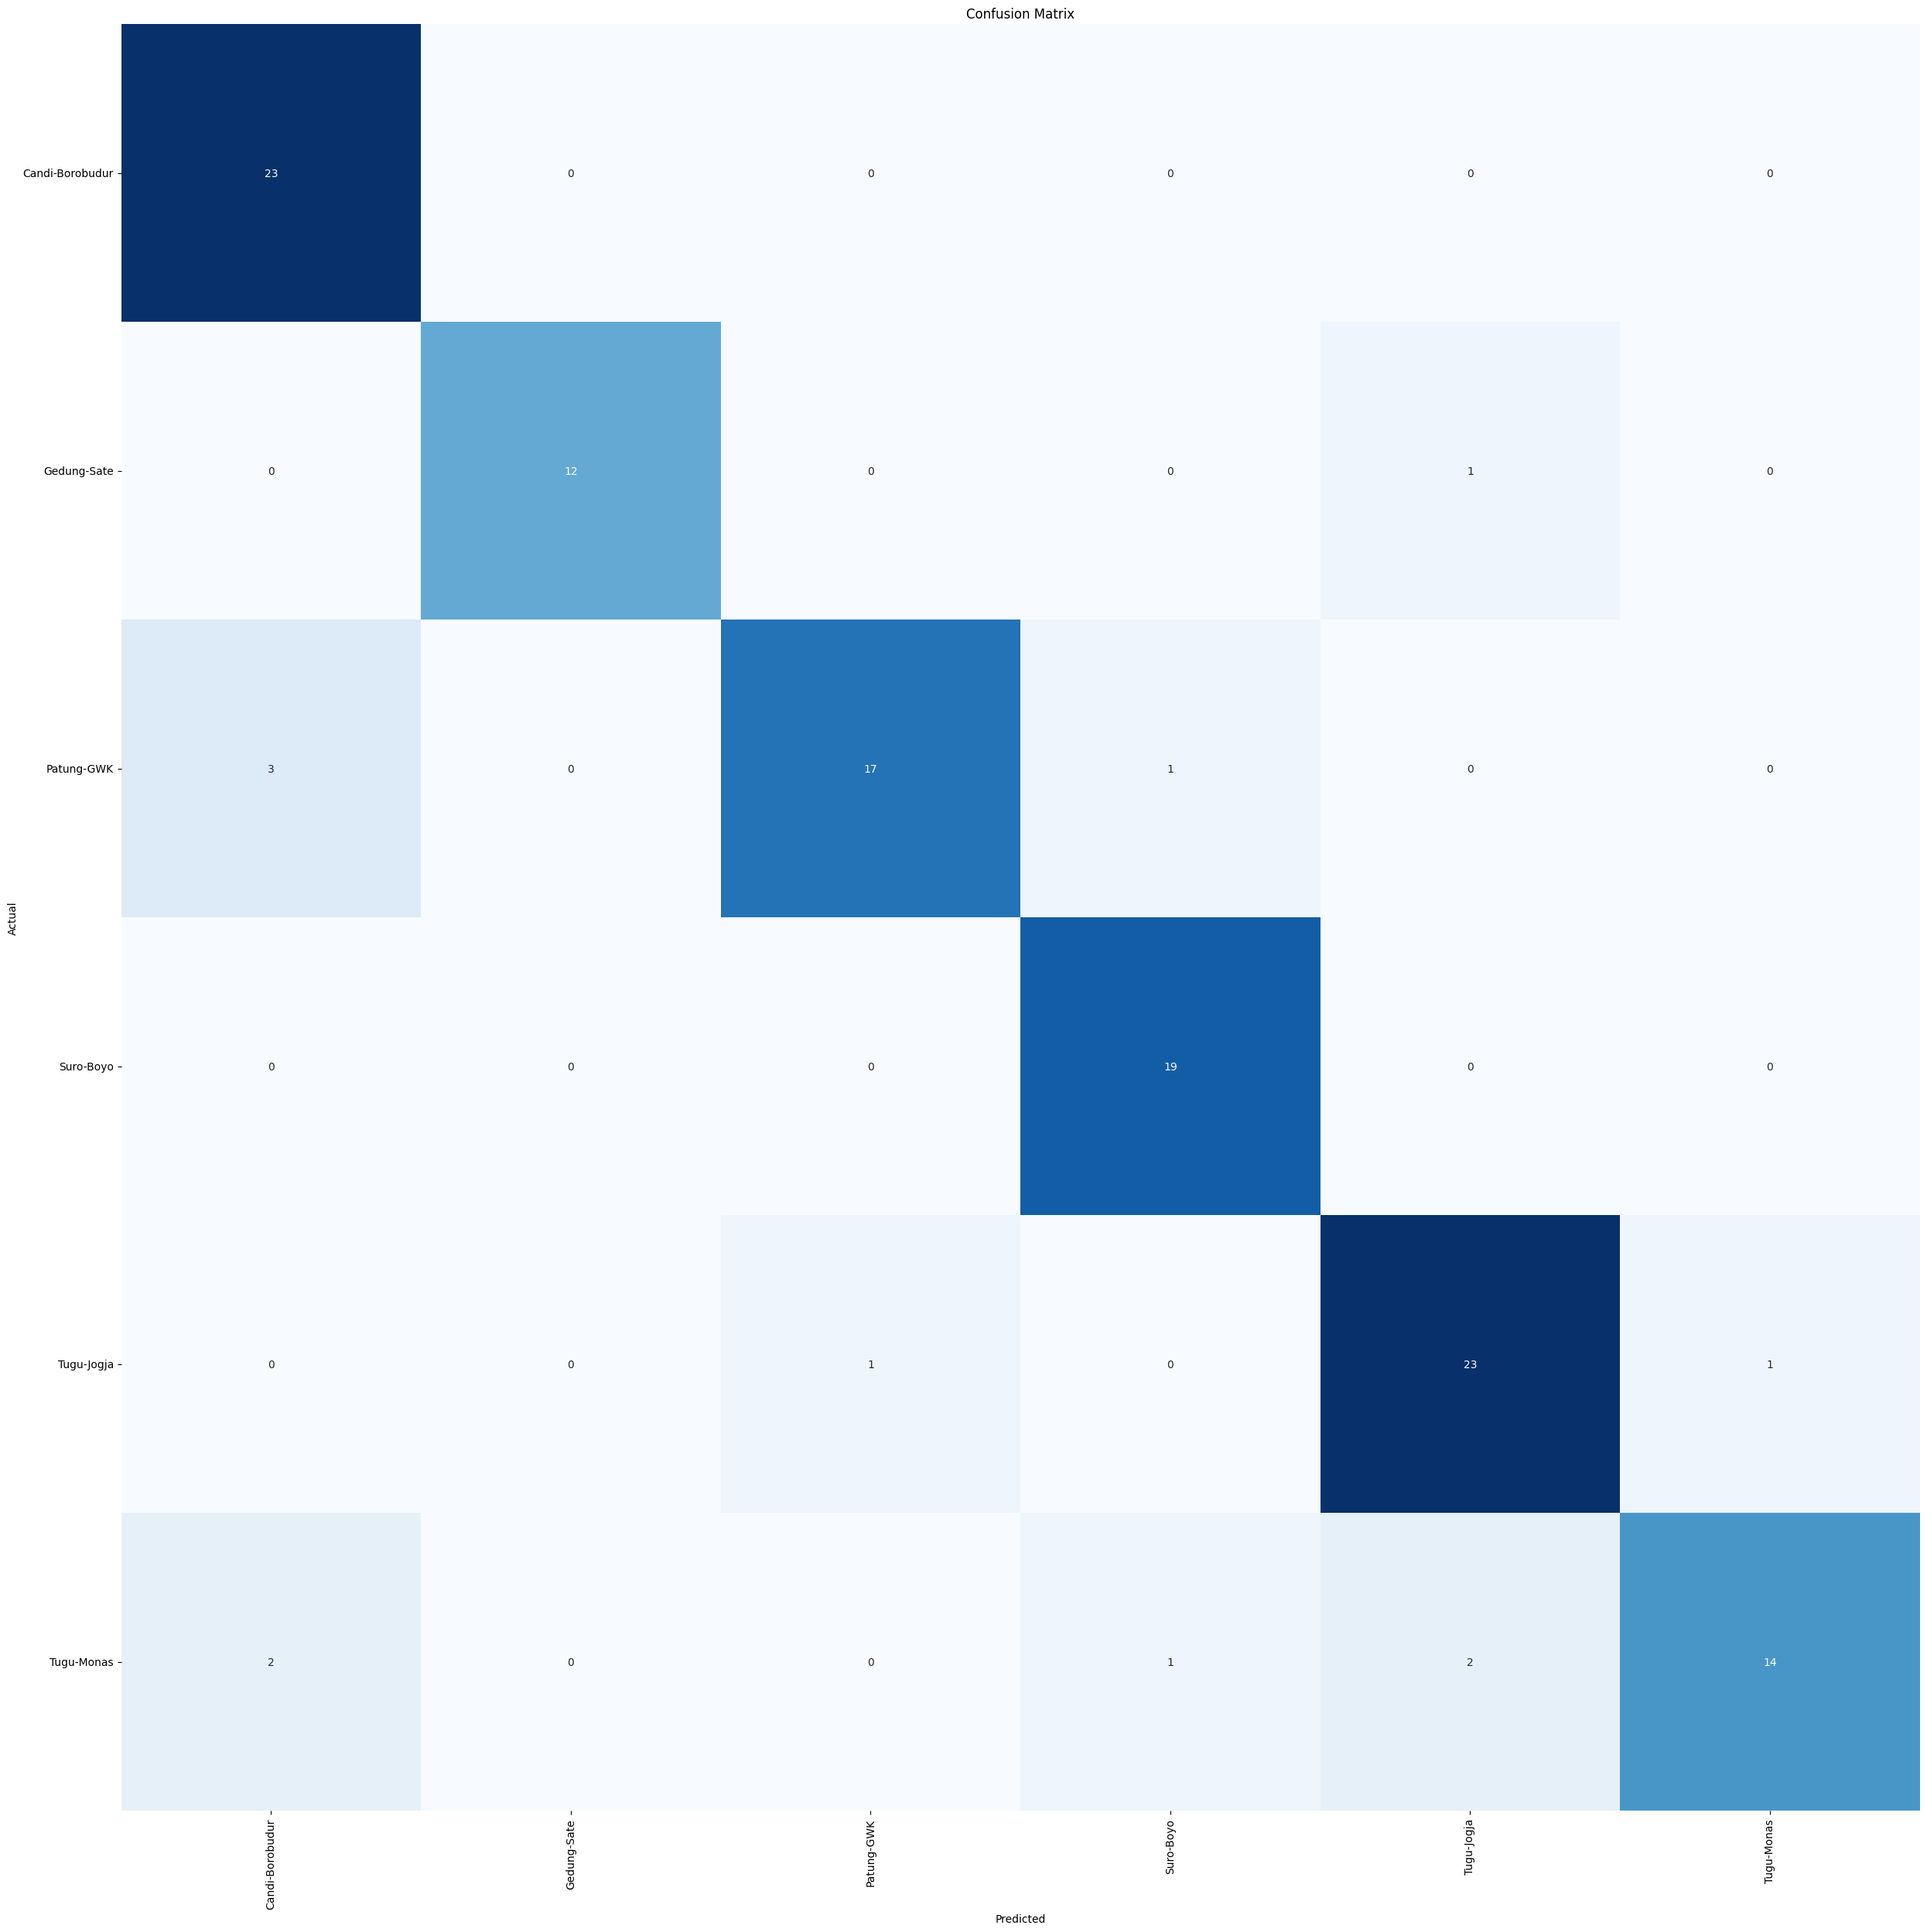

In [20]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(6) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(6) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

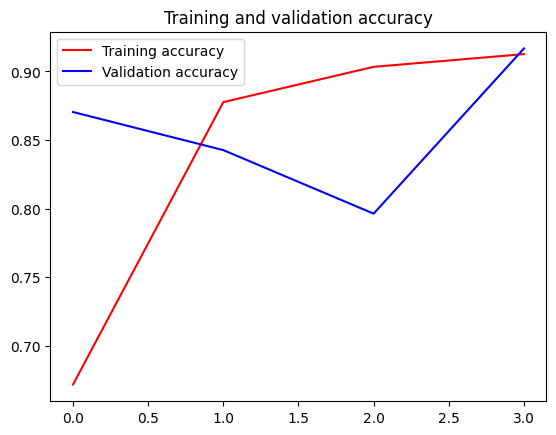

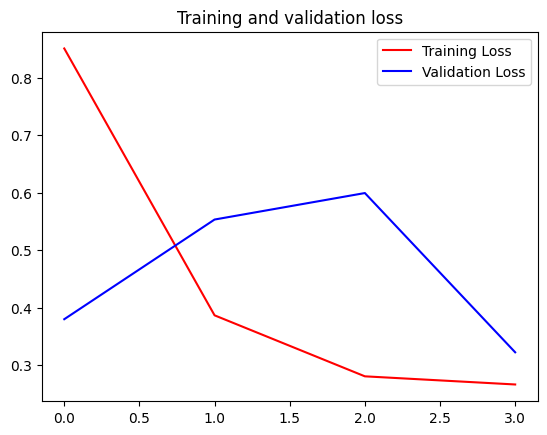

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [22]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                  precision    recall  f1-score   support

Candi-Borobudur       0.82      1.00      0.90        23
    Gedung-Sate       1.00      0.92      0.96        13
     Patung-GWK       0.94      0.81      0.87        21
      Suro-Boyo       0.90      1.00      0.95        19
     Tugu-Jogja       0.88      0.92      0.90        25
     Tugu-Monas       0.93      0.74      0.82        19

       accuracy                           0.90       120
      macro avg       0.91      0.90      0.90       120
   weighted avg       0.91      0.90      0.90       120



In [23]:
!pip install pyyaml h5py

In [24]:
model.save('Landmark-R.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
%pwd

'/content'

In [ ]:
%cd gdrive/MyDrive/Landmark-Recognition/

[Errno 2] No such file or directory: '/gdrive/MyDrive/Landmark-Recognition/'
/content


In [25]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

labels = ["Candi-Borobudur", "Gedung-Sate", "Patung-GWK", "Suro-Boyo", "Tugu-Jogja", "Tugu-Monas"]

for fn in uploaded.keys():
    # predicting images
    path = '/content/gdrive/MyDrive/Landmark-Recognition/' + fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=32)

    highest_score_index = np.argmax(classes)
    highest_score = classes[0][highest_score_index]
    highest_score_label = labels[highest_score_index]

    print(classes)
    print("Highest Score:", highest_score)
    print("Highest Score Label:", highest_score_label)


Saving Test-Monas.jpg to Test-Monas (1).jpg
1/1 [==============================] - 2s 2s/step
[[1.6520442e-03 3.8787493e-05 3.0460220e-03 1.4745889e-05 2.0422828e-03
  9.9320614e-01]]
Highest Score: 0.99320614
Highest Score Label: Tugu-Monas
